## Instacart Market Analysis

    
<br>

Use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. 

***


In [2]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# import data
orders = pd.read_csv("./orders.csv")
order_prior = pd.read_csv("./order_products_prior.csv")
order_train = pd.read_csv("./order_products_train.csv")
aisles = pd.read_csv("./aisles.csv")
departments = pd.read_csv("./departments.csv")

In [4]:
# Look at head of data
orders.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0


In [5]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
aisles.head(2)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


In [8]:
departments.head(2)

,department_id,department
0,1,frozen
1,2,other


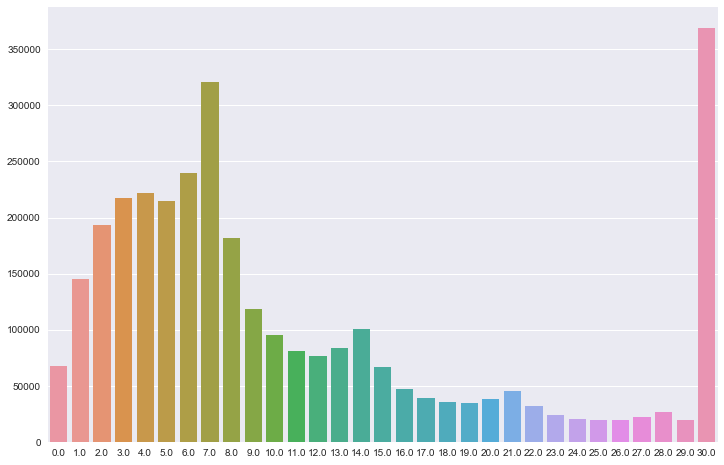

In [26]:
# how long is item being reordered?
reorder_period = orders.days_since_prior_order.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(reorder_period.index, reorder_period.values)
plt.show()

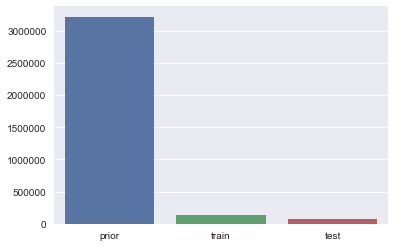

In [30]:
# train test prio proportion
datatype = orders.eval_set.value_counts()
plt.figure(figsize=(6,4))
sns.barplot(datatype.index, datatype.values)
plt.show()

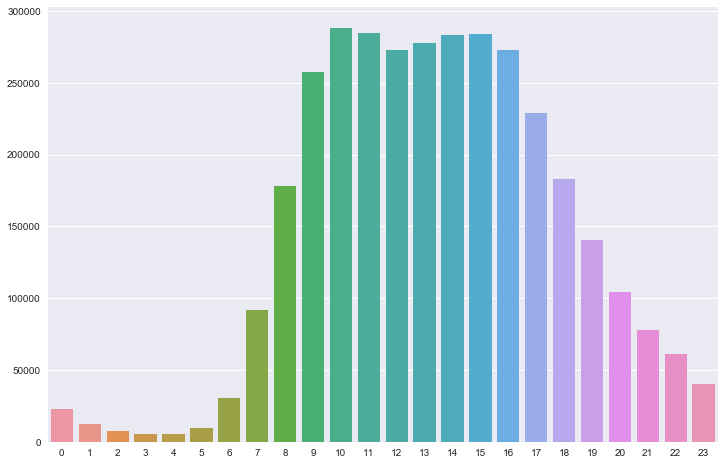

In [31]:
# order hours of the day
hour = orders.order_hour_of_day.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(hour.index, hour.values)
plt.show()

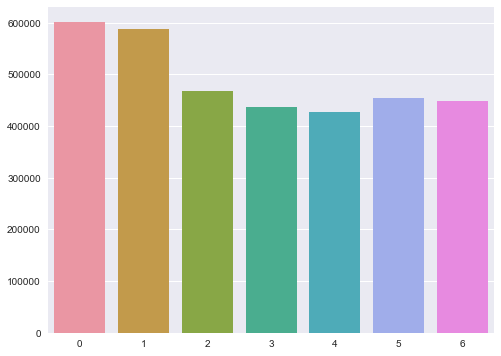

In [32]:
# order day of week
dow = orders.order_dow.value_counts()
plt.figure(figsize=(8,6))
sns.barplot(dow.index, dow.values)
plt.show()

In [5]:
# From training data, check how many items have been ordered in one order
order_train.groupby("order_id").head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
8,36,39612,1,0
9,36,19660,2,1
10,36,49235,3,0
11,36,43086,4,1
12,36,46620,5,1
